In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cấu hình đường dẫn đầu vào/đầu ra
model_name = "LogisticRegression"
input_folder = 'folder_standardized'
output_folder = 'models_and_results'
os.makedirs(output_folder, exist_ok=True)

print("--- KHỞI TẠO LOGISTIC REGRESSION ---")

--- KHỞI TẠO LOGISTIC REGRESSION ---


# MODEL 1: LogisticRegression

In [3]:
def load_data():
    """
    Đọc dữ liệu đã xử lý từ folder_standardized (kết quả của processing.ipynb).
    
    Returns:
        tuple: (X_train, y_train, X_test, y_test) - Bộ dữ liệu huấn luyện và kiểm tra
        
    Raises:
        FileNotFoundError: Nếu không tìm thấy dữ liệu đã xử lý
    """
    print("\n1. LOAD DATA")
    try:
        X_train = pd.read_csv(os.path.join(input_folder, 'X_train.csv'))
        y_train = pd.read_csv(os.path.join(input_folder, 'y_train.csv')).values.ravel()
        X_test = pd.read_csv(os.path.join(input_folder, 'X_test.csv'))
        y_test = pd.read_csv(os.path.join(input_folder, 'y_test.csv')).values.ravel()
        
        print(f"   - Đọc dữ liệu thành công")
        print(f"   - X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"   - X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
        return X_train, y_train, X_test, y_test
    except FileNotFoundError:
        print("   ✗ Lỗi: Không tìm thấy dữ liệu trong folder. Hãy chạy processing.ipynb trước!")
        exit()

X_train, y_train, X_test, y_test = load_data()


1. LOAD DATA
   - Đọc dữ liệu thành công
   - X_train shape: (5616, 34), y_train shape: (5616,)
   - X_test shape: (1405, 34), y_test shape: (1405,)


In [4]:
def train_model():
    """
    Huấn luyện mô hình Logistic Regression với tối ưu hóa tham số.
    
    Quy trình:
    1. Xây dựng Pipeline gồm SMOTE (cân bằng dữ liệu) + Logistic Regression
    2. Sử dụng GridSearchCV để tìm tham số tối ưu (C, class_weight, solver)
    3. Tối ưu hóa theo điểm F1 (cân bằng giữa Precision và Recall)
    4. Tìm ngưỡng phân loại tối ưu để cải thiện hiệu suất
    
    Returns:
        tuple: (best_model, best_threshold, y_prob) - Model, ngưỡng tối ưu, xác suất dự đoán
    """
    print(f"\n2. TRAIN MODEL: {model_name}")
    
    # Pipeline: SMOTE (xử lý class imbalance) -> Logistic Regression
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', LogisticRegression(random_state=42, max_iter=2000))
    ])
    
    # Lưới tham số cần thử
    param_grid = {
        'model__C': [0.01, 0.1, 1, 10, 100],          # Độ mạnh regularization (nhỏ = regularize mạnh)
        'model__class_weight': [None, 'balanced'],    # Cân bằng trọng số giữa 2 class
        'model__solver': ['lbfgs', 'liblinear']       # Thuật toán tối ưu hóa
    }
    
    # GridSearchCV: Vét cạn tất cả kết hợp tham số (Logistic chạy nhanh)
    search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='f1',     # Tối ưu hóa theo F1-score
        cv=5,             # 5-fold cross-validation
        verbose=1,
        n_jobs=-1         # Sử dụng tất cả CPU cores
    )
    
    print("   ℹ Đang tìm tham số tối ưu (GridSearchCV)...")
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    print(f"   - Tham số tốt nhất: {search.best_params_}")
    
    # Tìm ngưỡng phân loại tối ưu
    from sklearn.metrics import precision_recall_curve
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    print(f"   - Ngưỡng phân loại tối ưu: {best_threshold:.4f}")
    
    return best_model, best_threshold, y_prob

best_model, best_threshold, y_prob = train_model()


2. TRAIN MODEL: LogisticRegression
   ℹ Đang tìm tham số tối ưu (GridSearchCV)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
   - Tham số tốt nhất: {'model__C': 100, 'model__class_weight': None, 'model__solver': 'liblinear'}
   - Ngưỡng phân loại tối ưu: 0.4108


In [5]:
def evaluate_model(best_threshold, y_prob):
    """
    Đánh giá hiệu suất mô hình trên tập Test với ngưỡng tối ưu.
    
    Args:
        best_threshold (float): Ngưỡng phân loại tối ưu (0-1)
        y_prob (ndarray): Xác suất dự đoán class=1 từ mô hình
    
    Returns:
        ndarray: Dự đoán nhị phân (0 hoặc 1) sau áp dụng ngưỡng
    """
    print("\n3. EVALUATE MODEL")
    
    # Áp dụng ngưỡng phân loại tối ưu
    y_pred = (y_prob >= best_threshold).astype(int)
    
    # Hiển thị báo cáo phân loại chi tiết
    print(f"   - Dự đoán với ngưỡng {best_threshold:.4f}:")
    print("\n" + classification_report(y_test, y_pred, 
                                      target_names=['No Churn', 'Yes Churn']))
    
    return y_pred

y_pred = evaluate_model(best_threshold, y_prob)


3. EVALUATE MODEL
   - Dự đoán với ngưỡng 0.4108:

              precision    recall  f1-score   support

    No Churn       0.91      0.74      0.81      1053
   Yes Churn       0.50      0.79      0.61       352

    accuracy                           0.75      1405
   macro avg       0.71      0.76      0.71      1405
weighted avg       0.81      0.75      0.76      1405




4. VISUALIZE CONFUSION MATRIX


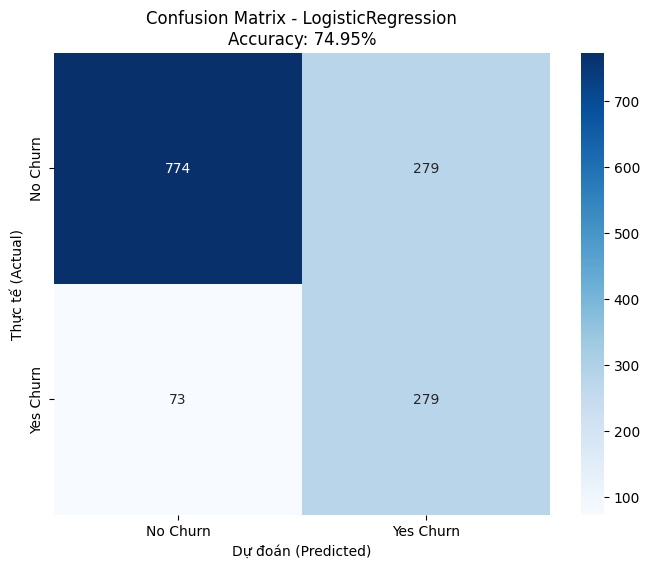

   - Lưu biểu đồ Confusion Matrix tại: models_and_results\LogisticRegression_confusion_matrix.png


In [6]:
def visualize_confusion_matrix(y_pred):
    """
    Vẽ và lưu ma trận nhầm lẫn (Confusion Matrix) dưới dạng heatmap.
    
    Args:
        y_pred (ndarray): Dự đoán nhị phân (0 hoặc 1)
    """
    print("\n4. VISUALIZE CONFUSION MATRIX")
    
    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Vẽ heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Yes Churn'], 
                yticklabels=['No Churn', 'Yes Churn'])
    plt.title(f'Confusion Matrix - {model_name}\nAccuracy: {accuracy:.2%}')
    plt.ylabel('Thực tế (Actual)')
    plt.xlabel('Dự đoán (Predicted)')
    
    # Lưu biểu đồ
    img_path = os.path.join(output_folder, f'{model_name}_confusion_matrix.png')
    plt.savefig(img_path, dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"   - Lưu biểu đồ Confusion Matrix tại: {img_path}")

visualize_confusion_matrix(y_pred)

In [7]:
def save_model(best_model):
    """
    Lưu mô hình đã huấn luyện để sử dụng trong bước Prediction sau này.
    
    Args:
        best_model (Pipeline): Mô hình đã huấn luyện (Pipeline với SMOTE + LogisticRegression)
    """
    print("\n5. SAVE MODEL")
    
    # Lưu mô hình dưới dạng pickle file
    model_path = os.path.join(output_folder, f'{model_name}.pkl')
    joblib.dump(best_model, model_path)
    
    print(f"   - Lưu mô hình tại: {model_path}")
    print(f"   → Sẽ dùng cho predict.ipynb")

save_model(best_model)


5. SAVE MODEL
   - Lưu mô hình tại: models_and_results\LogisticRegression.pkl
   → Sẽ dùng cho predict.ipynb
